# Building Good Training Datasets - Data Preprocessing

## Dealing With Missing Data

In [1]:
import pandas as pd
from io import StringIO
csv_data = \
    '''A,B,C,D
    1.0,2.0,3.0,4.0
    5.0,6.0,,8.0
    10.0,11.0,12.0,'''
    
# If you are using Python 2.7, you need
# to convert the string to unicode:
# csv_data = unicode(csv_data)
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


### Imputing Missing Values

In [2]:
from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [3]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


### Handling Categorical Data

**Ordinal features** can be understood as categorical values that can be sorted or ordered.
For ex, t-shirt size, XL > L > M

**Nominal features** don't imply any order.
For ex, t-shirt color 

In [4]:
import pandas as pd
df = pd.DataFrame([
    ['green', 'M', 10.1, 'class2'],
    ['red', 'L', 13.5, 'class1'],
    ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [5]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [6]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}

df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

### Encoding Class Labels

In [7]:
import numpy as np

class_mapping = {label: idx for idx, label in
enumerate(np.unique(df['classlabel']))}

class_mapping

{'class1': 0, 'class2': 1}

In [8]:
df['classlabel'] = df['classlabel'].map(class_mapping)

df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [9]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

In [10]:
class_le.inverse_transform(y)

array([1, 0, 1])

### Performing One-Hot Encoding On Nominal Features

In [11]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()

X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [12]:
from sklearn.preprocessing import OneHotEncoder

X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [13]:
from sklearn.compose import ColumnTransformer

X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([
        ('onehot', OneHotEncoder(), [0]),
        ('nothing', 'passthrough', [1, 2])
        ])

c_transf.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [14]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,False,True,False
1,13.5,2,False,False,True
2,15.3,3,True,False,False


When we are using one-hot encoding datasets, we have to keep in mind that this introduces multicollinearity, which can bea n issue for certain methods (for instance, for methods that requite matrix inversion). If features are highly correlated, matrices are computationally difficul to invert, which can lead to numerically unstable estimates. To reduce the correlation among variables we can simply remove one feature column from the one hot encoded array.

In [15]:
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,True,False
1,13.5,2,False,True
2,15.3,3,False,False


In [16]:
color_ohe = OneHotEncoder(categories='auto', drop='first')
c_transf = ColumnTransformer([
        ('onehot', color_ohe, [0]),
        ('nothing', 'passthrough', [1, 2])
        ])
c_transf.fit_transform(X).astype(float)

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

### Partitioning a Dataset Into Separate Training and Test Datasets

In [17]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
            'ml/machine-learning-databases/'
            'wine/wine.data', header=None)

In [18]:
df_wine.columns = ['Class label', 'Alcohol',
    'Malic acid', 'Ash',
    'Alcalinity of ash', 'Magnesium',
    'Total phenols', 'Flavanoids',
    'Nonflavanoid phenols',
    'Proanthocyanins',
    'Color intensity', 'Hue',
    'OD280/OD315 of diluted wines',
    'Proline']

print('Class labels', np.unique(df_wine['Class label']))

Class labels [1 2 3]


In [19]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [20]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test =\
train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

## Bringing Features Onto The Same Scale

**Decision trees** an **random forests** are two of the very few ml algorithms where we don't need to worry about feature scaling. 

There are two common approaches to bringing different features onto the same scale: **normalization** and **standarization**. Most often, normalization refers to the rescaling of the features to a range of [0,1], which is a special case of **min-max scaling**. To normalize out data, we can simply apply the min-man scaling to each feature column in the following way:

![Alt text](../images/14.png)

In [21]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

Although normalization via min-max scaling is a commonly used technique that is useful when we need values in a bounded interval, standatization can be more practical for many ml algorithms, especially for optimization algorithms such as gradient descent. The reason is that many models, such as logistic regression and SVM, initialize the weights to 0 or small random values close to 0. Using standarization, we center the feature columns at mean 0 with standard deviation 1 so that the feature columns have the same parameters as a standard normal distribution, which makes it easier to learn the weights. However, standarization does not change the shape of the distribution, and it does not transform non-normally distributed data into normally distributed data. Additionally, standatization maintains useful information about outliers and makes the algorithm less sensitive to them in contrast to min-man scaling, which scales the data to a limited range of values.

Standarization:

![Alt text](../images/15.png)

In [22]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Selecting Meaningful Features

### L1 and L2 Regularization As Penalties Against Model Complexity

In [23]:
from sklearn.linear_model import LogisticRegression

LogisticRegression(penalty='l1',
                solver='liblinear',
                multi_class='ovr')

LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear')

In [24]:
lr = LogisticRegression(penalty='l1',
                        C=1.0,
                        solver='liblinear',
                        multi_class='ovr')

# Note that C=1.0 is the default. You can increase
# or decrease it to make the regularization effect
# stronger or weaker, respectively.

lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


/home/nathalie/Desktop/projects/ml-book/ml-book/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [25]:
lr.intercept_

array([-1.26397261, -1.21577621, -2.37008136])

In [26]:
lr.coef_

array([[ 1.24591737,  0.1805989 ,  0.7463471 , -1.16394466,  0.        ,
         0.        ,  1.15940941,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55705677,  2.50875158],
       [-1.53863603, -0.38580286, -0.99523537,  0.363709  , -0.05901168,
         0.        ,  0.66675646,  0.        ,  0.        , -1.93210431,
         1.2376782 ,  0.        , -2.23330454],
       [ 0.1358871 ,  0.16837023,  0.35724016,  0.        ,  0.        ,
         0.        , -2.43829845,  0.        ,  0.        ,  1.56387049,
        -0.81892846, -0.49228764,  0.        ]])

/home/nathalie/Desktop/projects/ml-book/ml-book/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/nathalie/Desktop/projects/ml-book/ml-book/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/nathalie/Desktop/projects/ml-book/ml-book/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/n

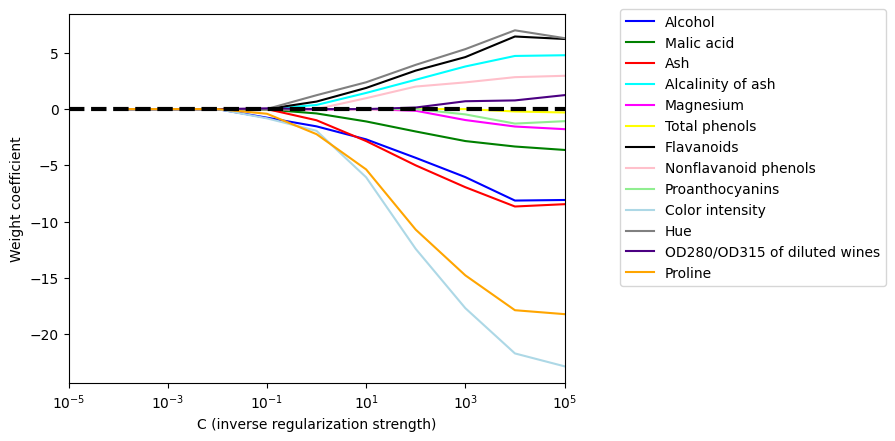

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan',
        'magenta', 'yellow', 'black',
        'pink', 'lightgreen', 'lightblue',
        'gray', 'indigo', 'orange']

weights, params = [], []

for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c,
    solver='liblinear',
    multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
    label=df_wine.columns[column + 1],
    color=color)
    
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('Weight coefficient')
plt.xlabel('C (inverse regularization strength)')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
bbox_to_anchor=(1.38, 1.03),
ncol=1, fancybox=True)
plt.show()

## Sequential FEature Selection Algorithms 

An alternative way to reduce the complexity of the model and avoid overfitting is **dimensionality reduction** via feature selection, which is especially useful for unregularized models. There are two main categories of dimensinality reduction techniques: **feature selection** and **feature extraction**. Via feature selection, we  select a subset of the original features, whereas in feature extraction, we derive information from te feature set to construct a new feature subspace. 

Sequential feature selection algorithms are a family of greedy search algorithms that are used to reduce an initial d-dimensional feature space to a k-dimensional feature space where k < d. The motivation behind feature selection algorithms is to automatically select a subset of features that are most relevant to the problem, to improve computational efficiency, or to reduce the generalization error of the model by removing irrelevant features or noise, which can be useful for algorithms that don't support generalization.

A classic sequential feature selection algorithm is **sequential backward selection (SBS)**, which aims to reduce the dimensionality of the initial feature subspace with a minimum decay in the performance of the classifier to improve upon computational efficiency. In certain cases, SBS can even improve the predictive power of the model if a model suffers from overfitting.

The idea behind SBS algorihtm is quite simple: SBS sequentially removes features from the full feature subset until the new feature subspace contains the desired number of features. To etermine which feature is to be removed at each stage, we need to define a criterion function J that we want to minimize.

The criterion calculated by the criterion function can simply be the difference in the performance of the classifier before and after the removal of a particular feature. Then, the feature to be removed at each stage can simply be defined as the feature that maximizes this criterion; or in more simple terms, at each stage we eliminate the feature that causes the least performance loss after removal. Based on the preceding definition of SBS, we can outline the algorithm in four simple steps:
1. Initialize the algorithm with k = d, where d is the dimensionality of the full feature space, Xd.
2. Determine the feature, x–
, that maximizes the criterion: x– = argmax J(Xk – x), where 𝒙𝒙𝒙𝒙𝒙𝑘𝑘.
3. Remove the feature, x–
, from the feature set: Xk–1 = Xk – x–
; k = k – 1.
4. Terminate if k equals the number of desired features; otherwise, go to step 2.

In [29]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS:
    def __init__(self, estimator, k_features,
        scoring=accuracy_score,
        test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=self.test_size,
        random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
        X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,
                                        X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [30]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

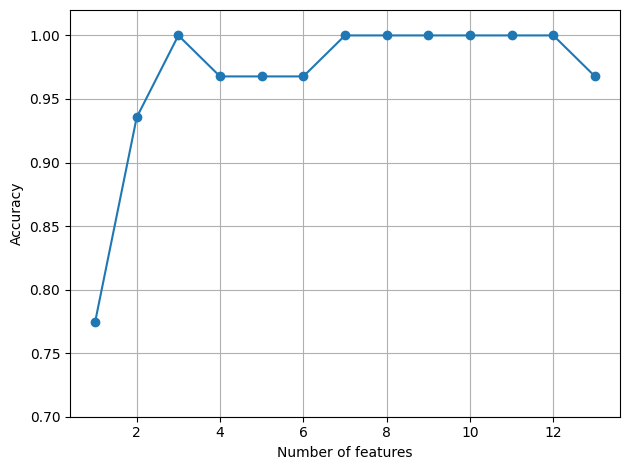

In [31]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [37]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [38]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In [39]:
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


## Assessing Feature Importance With Random Forests

Using random forests we can measure the feature importance as the averaged impurity decrease computed from all decison trees in the forest, without making any assumptions about whether our data is linearly separable or not. Conveniently, the random forest implementation in scikit learn already collects the feature importance values for us. 

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


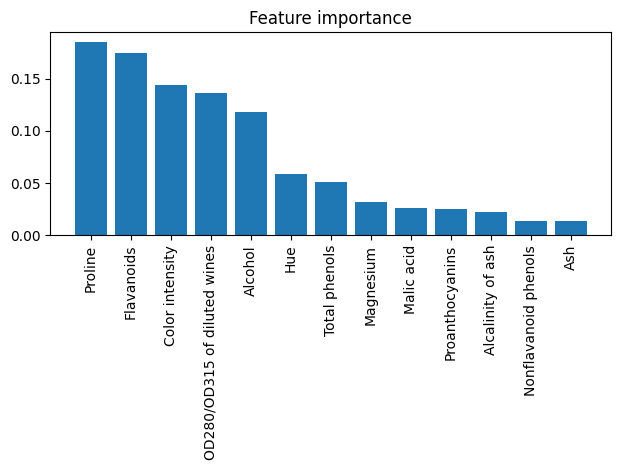

In [40]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.title('Feature importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

The catch with this is that if two or more features are highly correlated, one feature may be ranked very highly while the information on the other feature may not be fully captured. On the other hand, we dont need to be concerned about this problem if we are merely interested in the predictive performance of a model rather than the interpretation of feature  importance values.